In [1]:
import os
import sys

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import statsmodels.api as sm

from ema_workbench.analysis import prim, cart
from ema_workbench import ema_logging, load_results, MultiprocessingEvaluator, Constraint, Scenario
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.optimization import ArchiveLogger, EpsilonProgress

from ema_workbench import (
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)

from ema_workbench.em_framework.optimization import to_problem

from SALib.analyze import sobol

from problem_formulation import get_model_for_problem_formulation

In [2]:
problem_formulation_id = 6
dike_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)

uncertainties = [u.name for u in dike_model.uncertainties]
levers = [l.name for l in dike_model.levers]
ooi = [o.name for o in dike_model.outcomes]
ooi_dr3 = ['A.3_Expected Annual Damage', 'A.3_Expected Number of Deaths', 'A.3_Dike Investment Costs']

# General Analysis for OOI of Dike Ring 3
Goals
* Understand the OOI distribution
* Determine the thresholds for different OOI of Dike Ring 3

Steps
* Inspect the OOI distribution using: histogram and accumulative plots
* Identify threshold values for each OOI of Dike Ring 3

In [3]:
experiment, outcomes = load_results(os.path.join('experiment', 'pol0_sc500.tar.gz'))
df_outcomes = pd.DataFrame(outcomes)

In [4]:
df_outcomes.describe()

,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths
count,2.000000e+04,20000.0,20000.000000
mean,3.989421e+08,0.0,0.695917
std,6.419060e+08,0.0,1.094826
min,0.000000e+00,0.0,0.000000
25%,0.000000e+00,0.0,0.000000
50%,3.177951e+07,0.0,0.063880
75%,5.374712e+08,0.0,0.955720
max,2.527031e+09,0.0,3.216259


From the general stats of the 3 OOI for Dike Ring 3, it can be seen that A.3_Dike Investment Costs is 0 since there is no policy applied to these experiments. The general analysis of the OOI will focus on **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths**

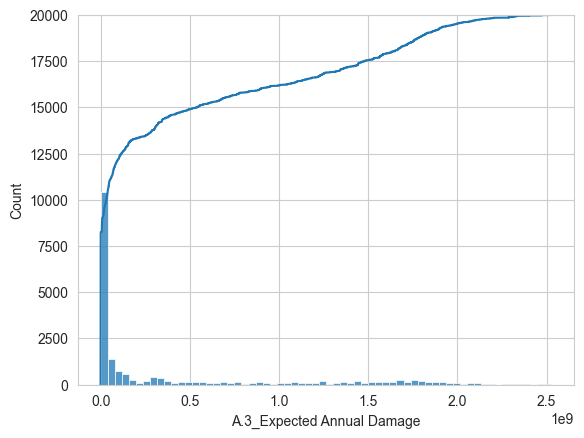

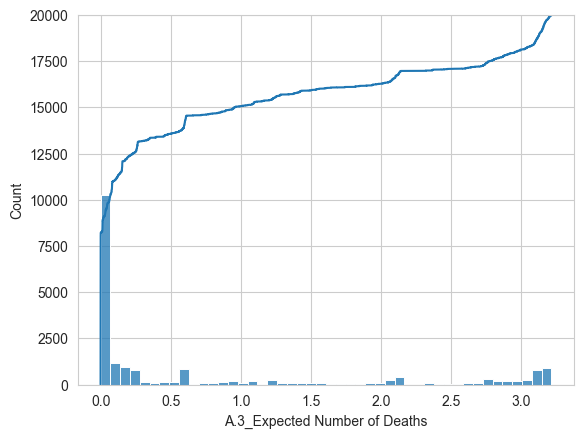

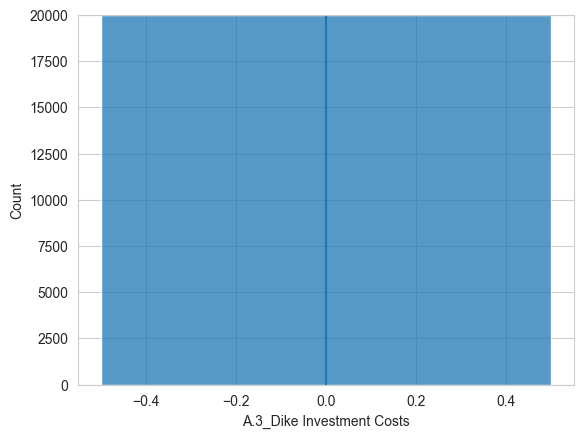

In [53]:
for o in ooi_dr3:
    sns.histplot(df_outcomes, x=o)
    sns.ecdfplot(df_outcomes, x=o, stat='count')
    plt.show()

The plots of the distributions of the OOI shows that for the status quo (i.e: no policy), the **A.3_Expected Annual Damage** and **A.3_Expected Number of Deaths** are relatively low.

The threshold for these 2 OOIs are taken as the 50th value.

## Relationship between A.3_Expected Annual Damage and A.3_Expected Number of Deaths

The stat model shows that there is a strong linear relationship between **A.3_Expected Number of Deaths** and **A.3_Expected Annual Damage** 

In [45]:
X = sm.add_constant(df_outcomes['A.3_Expected Annual Damage'])
Y = df_outcomes['A.3_Expected Number of Deaths']
regress_model_ooi = sm.OLS(Y,X)
regress_result_ooi = regress_model_ooi.fit()
regress_result_ooi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                 
=========================================================================================
Dep. Variable:     A.3_Expected Number of Deaths   R-squared:                       0.970
Model:                                       OLS   Adj. R-squared:                  0.970
Method:                            Least Squares   F-statistic:                 6.438e+05
Date:                           Thu, 06 Jun 2024   Prob (F-statistic):               0.00
Time:                                   09:54:40   Log-Likelihood:                 4834.0
No. Observations:                          20000   AIC:                            -9664.
Df Residuals:                              19998   BIC:                            -9648.
Df Model:                                      1                                         
Covariance Type:                       nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0258      0.002     16.317      0.000       0.023       0.029
A.3_Expected Annual Damage   1.68e-09   2.09e-12    802.400      0.000    1.68e-09    1.68e-09
==============================================================================
Omnibus:                     3724.338   Durbin-Watson:                   0.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80587.456
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                      12.816   Cond. No.                     8.90e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.9e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

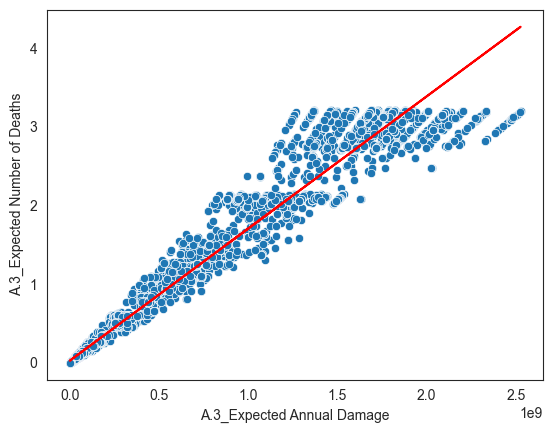

In [53]:
ax = plt.subplot()
y_graph = df_outcomes['A.3_Expected Annual Damage']*regress_result_ooi.params['A.3_Expected Annual Damage'] +  regress_result_ooi.params['const']
ax.plot(df_outcomes['A.3_Expected Annual Damage'], y_graph, color='r')
sns.scatterplot(df_outcomes, x='A.3_Expected Annual Damage', y='A.3_Expected Number of Deaths', ax=ax)
plt.show()

# Sensitivity analysis

Sensitivity analysis shows that:
* A.3_pfail has the most significant impact of the 2 OOIs of Dike Ring 3. This influence is mostly first order (i.e., the uncertainty has the impact by itself, not in combination with other uncertainties)
* A.1_pfail and A.2_pfail has some influence on the 2 OOIs of Dike Ring 3. These influence are much milder than that of A.3_pfail. Furthermore, these influences are not first order (i.e., they must be combined with other uncertainties)

This suggest that:
* Dike Ring 3 must push for policies to mitigate A.3_pfail as much as possible.
* Dike Ring 1 and 2 can be alliance since, mitigating their risks serve the cause of Dike Ring 3.

In [4]:
q_damage = 0.5
threshold_damage = df_outcomes['A.3_Expected Annual Damage'].quantile(q_damage)

q_death = 0.5
threshold_death = df_outcomes['A.3_Expected Number of Deaths'].quantile(q_damage)

## Linear regression

The stat model for the 2 OOIs has R-squared values approximately 0.6, meaning that about 60% of the data points can be explained by this regression model.

The coef for these 2 OOIs resulting from the stat model is rather inexplicable.

In [90]:
X_0 = sm.add_constant(experiment[uncertainties])
for key in ooi_dr3:
    est = sm.OLS(outcomes[key], X_0.astype(float)).fit()
    print('\n\n' + '*'*100 + '\n')
    print(key)
    print(est.summary())
    print('-'*20 + '\nSorted coef values' + '-'*20)
    print(est.params.sort_values())



****************************************************************************************************

A.3_Expected Annual Damage
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     1659.
Date:                Wed, 05 Jun 2024   Prob (F-statistic):               0.00
Time:                        19:12:15   Log-Likelihood:            -4.2451e+05
No. Observations:               20000   AIC:                         8.491e+05
Df Residuals:                   19980   BIC:                         8.492e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025

/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/homebrew/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:957: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/opt/homebrew/lib/python3.12/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in scalar divide
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


## Feature scoring

Feature scoring analysis shows that:
* the pfail of A.3 has the most influence on the 2 OOIs of dike ring 3.
* additionally the uncertainties dictating the failure (pfail) of dike ring A.1 has some influences on the 2 OOIs of dike ring 3, albeit not as significant. 
* additionally the uncertainties dictating the failure (pfail) of dike ring A.2 has some influences on the 2 OOIs of dike ring 3, albeit not less significant than that of A.1.

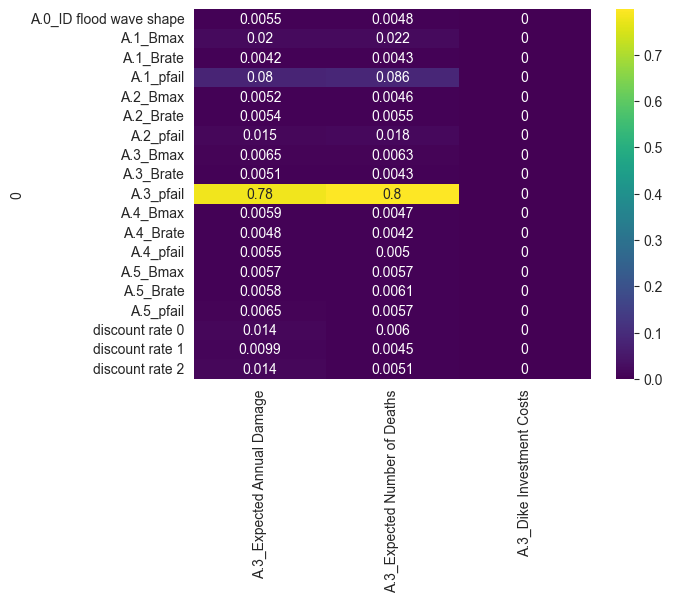

In [92]:
scores = feature_scoring.get_feature_scores_all(experiment[uncertainties], df_outcomes[ooi_dr3],
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=True, cmap='viridis')
plt.show()

## Sobol Indices

Sobol Indices analysis shows that:
* the pfail of A.3 has the most influence on the 2 OOIs of dike ring 3. This impact is primarily first order,
* additionally the uncertainties dictating the failure (pfail) of dike rings A.1 and A.2 also have somce influences on the 2 OOIs of dike ring 3, albeit not as significant. These impacts are not primarily first order impacts, indicating that these uncertainties must be combined with other uncertainties to influence these OOIs.


****************************************************************************************************

A.3_Expected Annual Damage
                                   ST       ST_conf
A.0_ID flood wave shape  5.895603e-03  2.643271e-03
A.1_Bmax                 1.909834e-02  1.065367e-02
A.1_Brate                1.642223e-04  1.838320e-04
A.1_pfail                1.676805e-01  5.182303e-02
A.2_Bmax                 2.381791e-04  2.863859e-04
A.2_Brate                3.827300e-07  5.926203e-07
A.2_pfail                3.193679e-02  2.036278e-02
A.3_Bmax                 0.000000e+00  0.000000e+00
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                9.184977e-01  1.110354e-01
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                0.000000e+00  0.000000e+00
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                0.000000e+00 

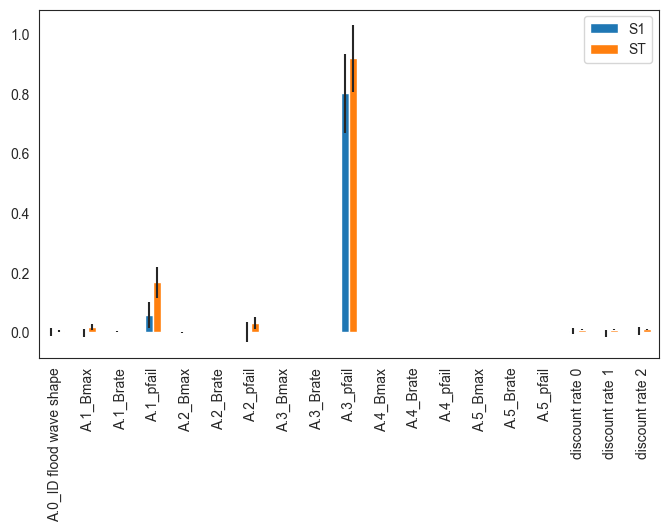


****************************************************************************************************

A.3_Expected Number of Deaths
                                   ST       ST_conf
A.0_ID flood wave shape  5.690504e-03  2.012619e-03
A.1_Bmax                 2.164792e-02  1.067465e-02
A.1_Brate                1.377938e-04  1.516332e-04
A.1_pfail                1.633267e-01  5.289747e-02
A.2_Bmax                 4.232157e-04  6.781233e-04
A.2_Brate                5.617616e-07  8.796585e-07
A.2_pfail                3.158118e-02  1.863694e-02
A.3_Bmax                 0.000000e+00  0.000000e+00
A.3_Brate                0.000000e+00  0.000000e+00
A.3_pfail                9.073108e-01  9.574210e-02
A.4_Bmax                 0.000000e+00  0.000000e+00
A.4_Brate                0.000000e+00  0.000000e+00
A.4_pfail                0.000000e+00  0.000000e+00
A.5_Bmax                 0.000000e+00  0.000000e+00
A.5_Brate                0.000000e+00  0.000000e+00
A.5_pfail                0.000000e+

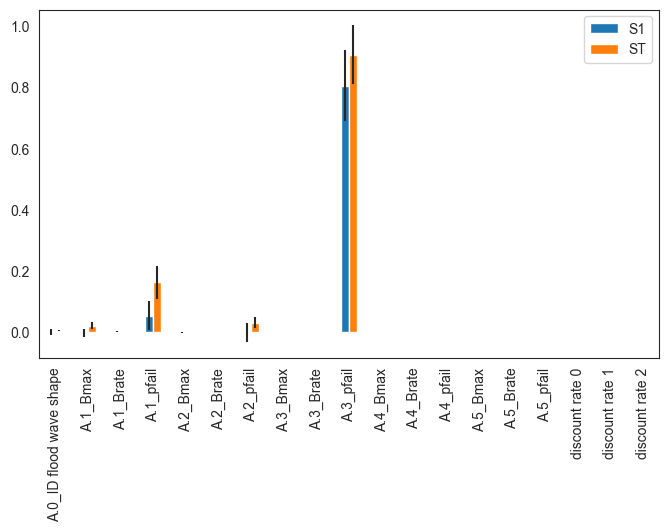


****************************************************************************************************

A.3_Dike Investment Costs


/opt/homebrew/lib/python3.12/site-packages/SALib/analyze/sobol.py:145: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


                         ST  ST_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A.2_pfail               NaN      NaN
A.3_Bmax                NaN      NaN
A.3_Brate               NaN      NaN
A.3_pfail               NaN      NaN
A.4_Bmax                NaN      NaN
A.4_Brate               NaN      NaN
A.4_pfail               NaN      NaN
A.5_Bmax                NaN      NaN
A.5_Brate               NaN      NaN
A.5_pfail               NaN      NaN
discount rate 0         NaN      NaN
discount rate 1         NaN      NaN
discount rate 2         NaN      NaN
                         S1  S1_conf
A.0_ID flood wave shape NaN      NaN
A.1_Bmax                NaN      NaN
A.1_Brate               NaN      NaN
A.1_pfail               NaN      NaN
A.2_Bmax                NaN      NaN
A.2_Brate               NaN      NaN
A

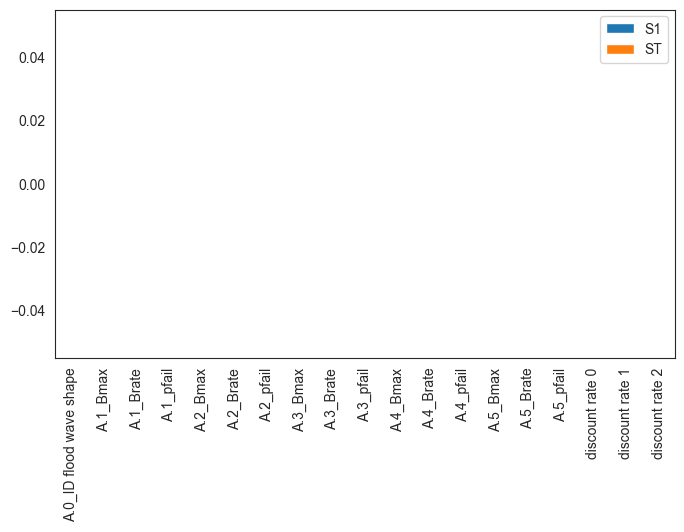

In [37]:
problem = get_SALib_problem(dike_model.uncertainties)
for key in ooi_dr3:
    print('\n' + '*'*100 + '\n')
    print(key)
    Si = sobol.analyze(problem, outcomes[key], calc_second_order=True, print_to_console=True)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    sns.set_style('white')
    fig, ax = plt.subplots(1)
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    
    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.show()
    
    # fig, axes = plt.subplots(1,3)
    # fig.set_size_inches(8, 4)
    # Si.plot(ax=axes)
    # plt.show()
    # si.plot()

# Scenario discovery
## PRIM
Goals
* Identify scenarios that are worse off for the OOI of Dike Ring 3.

Steps
* Use PRIM to find scenarios where **A.3_Expected Number of Death** is above the accepted threshold
* Use PRIM to find scenarios where **A.3_Expected Number of Death** and **A.3_Expected Annual Damage** is above the accepted threshold

Results
* A.2_pfail is between 0.52, 1
* A.1_Bmax is between 30, 3e2
* A.3_pfail is between 0, 0.48

These results are consistent with the sensitivity analysis (SOBOL, Feature scoring) above.

### A.3_Expected Number of Death

In [8]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

prim_alg_0_death = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death = prim_alg_0_death.find_box()

[MainProcess/INFO] 20000 points remaining, containing 9988 cases of interest
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '124.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.0944, coverage: 0.18902683219863836, density: 1.0 restricted_dimensions: 9


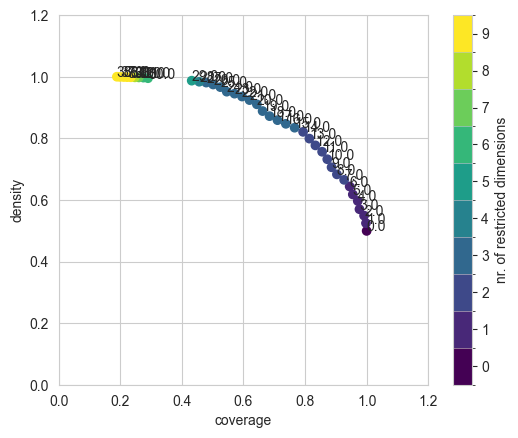

In [22]:
box1_0_death.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

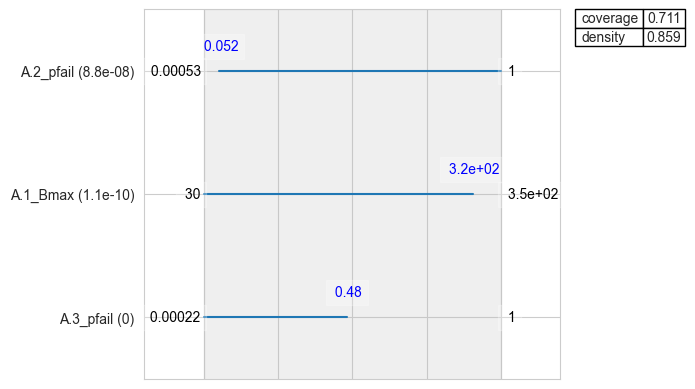

In [32]:
box1_0_death_index = box1_0_death.peeling_trajectory[(box1_0_death.peeling_trajectory.density >= 0.7) & (box1_0_death.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_index[-1])
box1_0_death.inspect(point, style='graph')

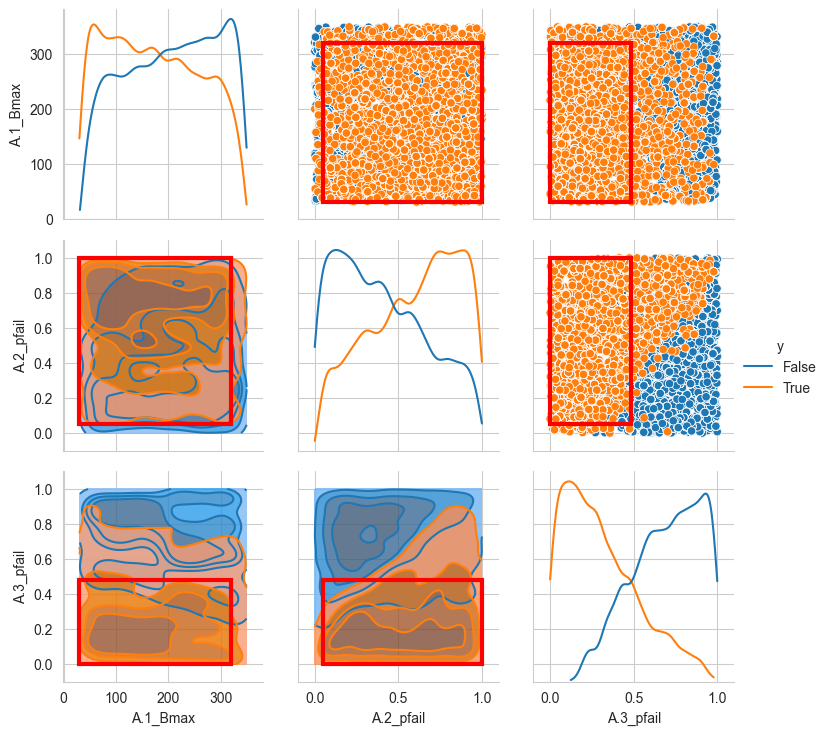

In [26]:
box1_0_death.show_pairs_scatter(point)

In [25]:
box1_0_death.resample(point)

[MainProcess/INFO] resample 0
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '124.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '124.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] resample 5
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in

,reproduce coverage,reproduce density
A.1_Bmax,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.0_ID flood wave shape,10.0,10.0
discount rate 0,0.0,0.0
discount rate 1,0.0,0.0
discount rate 2,0.0,0.0
A.1_pfail,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0


### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [27]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

prim_alg_0_death_damage = prim.Prim(x, y, threshold=0.8, peel_alpha=0.05)
box1_0_death_damage = prim_alg_0_death_damage.find_box()

[MainProcess/INFO] 20000 points remaining, containing 9898 cases of interest
/opt/homebrew/lib/python3.12/site-packages/ema_workbench/analysis/prim.py:1569: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '125.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  box_paste.loc[i, u] = paste_value
[MainProcess/INFO] mean: 1.0, mass: 0.0919, coverage: 0.18569407961204284, density: 1.0 restricted_dimensions: 9


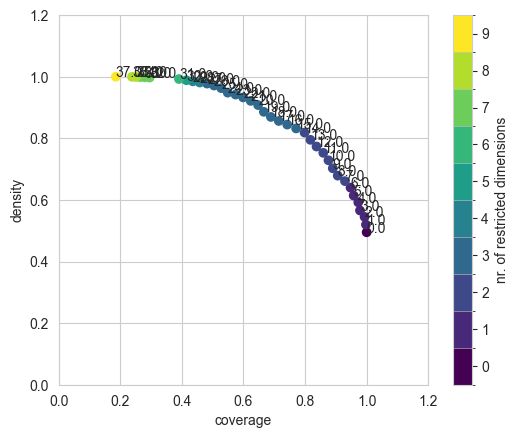

In [28]:
box1_0_death_damage.show_tradeoff(annotated=True)
plt.show()

[<Figure size 640x480 with 1 Axes>]

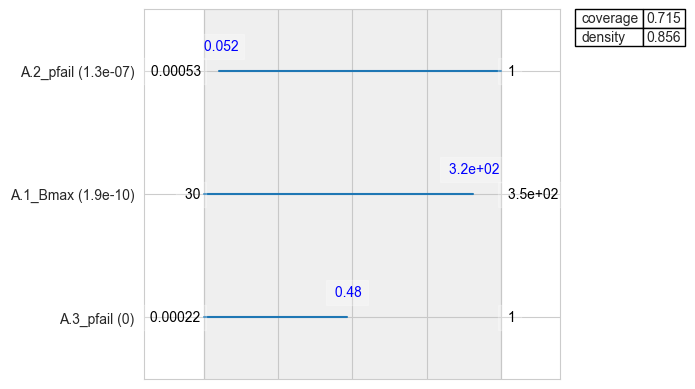

In [34]:
box1_0_death_damage_index = box1_0_death_damage.peeling_trajectory[(box1_0_death_damage.peeling_trajectory.density >= 0.7) & (box1_0_death_damage.peeling_trajectory.coverage >= 0.7)].index
point = int(box1_0_death_damage_index[-1])
box1_0_death_damage.inspect(point, style='graph')

## Cart
### A.3_Expected Number of Death

In [9]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = (df_outcomes['A.3_Expected Number of Deaths'] > threshold_death).values

cart_alg_0_death = cart.CART(x, y, 0.05)
cart_alg_0_death.build_tree()
cart_alg_0_death.boxes_to_dataframe()

box 1                  box 2                  box 3  \
                 min         max        min         max        min   
A.3_pfail   0.000225     0.19417    0.19417    0.422636   0.000225   
A.1_pfail   0.000068    0.332569   0.000068    0.332569   0.332569   
A.1_Bmax   30.198818  349.608147  30.198818  349.608147  30.198818   
A.2_pfail   0.000532    0.999265   0.000532    0.999265   0.000532   

                           box 4                  box 5              ...  \
                  max        min         max        min         max  ...   
A.3_pfail    0.422636   0.000225    0.422636   0.000225    0.422636  ...   
A.1_pfail    0.998965   0.332569    0.500958   0.500958    0.998965  ...   
A.1_Bmax   349.608147  30.198818  349.608147  30.198818  349.608147  ...   
A.2_pfail    0.268145   0.268145    0.999265   0.268145    0.999265  ...   

              box 10                  box 11                 box 12  \
                 min         max         min         max        min   
A.3_pfail   0.422636    0.998822    0.422636    0.998822   0.422636   
A.1_pfail   0.000068    0.484638    0.000068    0.484638   0.484638   
A.1_Bmax   30.198818  136.237007  136.237007  349.608147  30.198818   
A.2_pfail   0.476725    0.999265    0.476725    0.999265   0.476725   

                          box 13                 box 14              
                  max        min         max        min         max  
A.3_pfail    0.606772   0.606772    0.806561   0.806561    0.998822  
A.1_pfail    0.998965   0.484638    0.998965   0.484638    0.998965  
A.1_Bmax   349.608147  30.198818  349.608147  30.198818  349.608147  
A.2_pfail    0.999265   0.476725    0.999265   0.476725    0.999265  

[4 rows x 28 columns]

In [8]:
# fig = cart_alg_0_death.show_tree()
# fig.set_size_inches((18, 12))
# plt.show()

FileNotFoundError: [Errno 2] "dot" not found in path.

### A.3_Expected Number of Death and A.3_Expected Annual Damage

In [5]:
ema_logging.log_to_stderr(ema_logging.INFO)
x = experiment[uncertainties]
y = ((df_outcomes['A.3_Expected Number of Deaths'] > threshold_death) & (df_outcomes['A.3_Expected Annual Damage'] > threshold_damage)).values

cart_alg_0_death_damage = cart.CART(x, y, 0.05)
cart_alg_0_death_damage.build_tree()
cart_alg_0_death_damage.boxes_to_dataframe()

box 1                  box 2                  box 3  \
                 min         max        min         max        min   
A.3_pfail   0.000225     0.19417    0.19417    0.422636   0.000225   
A.1_pfail   0.000068    0.346711   0.000068    0.346711   0.346711   
A.1_Bmax   30.198818  349.608147  30.198818  349.608147  30.198818   
A.2_pfail   0.000532    0.999265   0.000532    0.999265   0.000532   

                           box 4                  box 5              ...  \
                  max        min         max        min         max  ...   
A.3_pfail    0.422636   0.000225    0.328234   0.328234    0.422636  ...   
A.1_pfail    0.998965   0.346711    0.998965   0.346711    0.998965  ...   
A.1_Bmax   349.608147  30.198818  349.608147  30.198818  349.608147  ...   
A.2_pfail    0.201818   0.201818    0.999265   0.201818    0.999265  ...   

              box 10                  box 11                 box 12  \
                 min         max         min         max        min   
A.3_pfail   0.422636    0.998822    0.422636    0.998822   0.422636   
A.1_pfail   0.000068    0.484638    0.000068    0.484638   0.484638   
A.1_Bmax   30.198818  136.237007  136.237007  349.608147  30.198818   
A.2_pfail   0.476725    0.999265    0.476725    0.999265   0.476725   

                          box 13                 box 14              
                  max        min         max        min         max  
A.3_pfail    0.606772   0.606772    0.806561   0.806561    0.998822  
A.1_pfail    0.998965   0.484638    0.998965   0.484638    0.998965  
A.1_Bmax   349.608147  30.198818  349.608147  30.198818  349.608147  
A.2_pfail    0.999265   0.476725    0.999265   0.476725    0.999265  

[4 rows x 28 columns]

In [65]:
num_boxes = len(cart_alg_0_death_damage.boxes)
scenarios_raw = cart_alg_0_death_damage.boxes_to_dataframe()[[(f'box {i+1}', 'max') for i in range(num_boxes)]]
scenarios_raw.columns = scenarios_raw.columns.get_level_values(0) + " " + scenarios_raw.columns.get_level_values(1)
scenarios_raw = scenarios_raw.rename(columns={col : '_'.join(col.split(" ")) for col in scenarios_raw.columns})

# create scenario dict to run optimize()
scenarios_dict = scenarios_raw.to_dict('dict')

# write scenarios to csv
scenarios_raw.to_csv(os.path.join('experiment', 'scenario_cart.csv'))

In [66]:
pd.read_csv(os.path.join('experiment', 'scenario_cart.csv')).rename(columns={'Unnamed: 0': 'uncertainties'}).set_index('uncertainties').to_dict('dict')

{'box_1_max': {'A.3_pfail': 0.1941698640584945,
  'A.1_pfail': 0.3467113971710205,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.9992654966190456},
 'box_2_max': {'A.3_pfail': 0.4226362854242325,
  'A.1_pfail': 0.3467113971710205,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.9992654966190456},
 'box_3_max': {'A.3_pfail': 0.4226362854242325,
  'A.1_pfail': 0.998965362086892,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.2018176242709159},
 'box_4_max': {'A.3_pfail': 0.3282338976860046,
  'A.1_pfail': 0.998965362086892,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.9992654966190456},
 'box_5_max': {'A.3_pfail': 0.4226362854242325,
  'A.1_pfail': 0.998965362086892,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.9992654966190456},
 'box_6_max': {'A.3_pfail': 0.5363428294658661,
  'A.1_pfail': 0.998965362086892,
  'A.1_Bmax': 349.6081465482712,
  'A.2_pfail': 0.4767245054244995},
 'box_7_max': {'A.3_pfail': 0.6502876877784729,
  'A.1_pfail': 0.998965362086892,
  'A.1_Bma

In [59]:
for data in scenarios_dict.values():
    for key, value in data.items():
        print(key)
        # scen.update({key: scenario[key]})

A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail
A.3_pfail
A.1_pfail
A.1_Bmax
A.2_pfail


# MOEA

To do
* Select new thresholds for **A.3_Expected Number of Deaths** and **A.3_Annual Damage Cost** : 90th percentile. This is because for the these bad scenarios, these 2 OOIs are in the upper 50th percentile of the distributions. Using MOEA to aleviate the impact in the upper 50th percentile of the distribution.

In [26]:
# look at optimal results to set threshold values for OOIs
experiment_sample, outcomes_sample = load_results(os.path.join('experiment', 'results_pol6_prb7_sd0.tar.gz'))
df_outcomes_sample = pd.DataFrame(outcomes)
df_outcomes_sample.describe()

[MainProcess/INFO] results loaded successfully from /Users/nhitran/Documents/TU_Delft/Q4/epa141A_final_assignment/epa141A_Labs_Group_Asians/final assignment/experiment/results_pol6_prb7_sd0.tar.gz


,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths
count,2.000000e+04,20000.0,20000.000000
mean,3.989421e+08,0.0,0.695917
std,6.419060e+08,0.0,1.094826
min,0.000000e+00,0.0,0.000000
25%,0.000000e+00,0.0,0.000000
50%,3.177951e+07,0.0,0.063880
75%,5.374712e+08,0.0,0.955720
max,2.527031e+09,0.0,3.216259


In [20]:
q_damage = 0.90
threshold_damage = df_outcomes['A.3_Expected Annual Damage'].quantile(q_damage)
threshold_investment = 10e9

q_death = 0.90
threshold_death = df_outcomes['A.3_Expected Number of Deaths'].quantile(q_damage)

print(f'Threshold death {threshold_death} person')
print(f'Threshold damage {threshold_damage} euro')
print(f'Threshold investment {threshold_investment} euro')

Threshold death 2.9575126496555004 person
Threshold damage 1631988901.8268845 euro
Threshold investment 10000000000.0 euro


In [21]:
dummy_model, planning_step = get_model_for_problem_formulation(problem_formulation_id)
for u in dummy_model.levers:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')
    
for u in dummy_model.outcomes:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')

for u in dummy_model.uncertainties:
    u.name = 'z_' + '_'.join(u.name.split(" "))
    u.name = u.name.replace('.', 'z')

def calculate_metrics(archives, reference_set, model=dummy_model):
    problem = to_problem(model, searchover="levers")

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

<>:51: SyntaxWarning: invalid escape sequence '\e'
<>:51: SyntaxWarning: invalid escape sequence '\e'
/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_30028/4136846217.py:51: SyntaxWarning: invalid escape sequence '\e'
  ax2.set_ylabel("$\epsilon$ progress")


In [9]:
reference_values = {
        "Bmax": 175,
        "Brate": 1.5,
        "pfail": 0.5,
        "ID flood wave shape": 4,
        "planning steps": 2,
    }
reference_values.update({f"discount rate {n}": 3.5 for n in planning_step})
scen1 = {}

for key in dike_model.uncertainties:
    name_split = key.name.split("_")

    if len(name_split) == 1:
        scen1.update({key.name: reference_values[key.name]})

    else:
        scen1.update({key.name: reference_values[name_split[1]]})

for key in scenarios_dict['box 1']:
    scen1.update({key: scenarios_dict['box 1'][key]})

ref_scenario = Scenario("reference", **scen1)

In [22]:
convergence_metrics = [ArchiveLogger(
                        "experiment",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimize_test.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]


constraints = [Constraint("max expected number of death", outcome_names="A.3_Expected Number of Deaths",
                          function=lambda x:max(0, x-threshold_death)),
               Constraint("max expected annual damage", outcome_names="A.3_Expected Annual Damage",
                          function=lambda x:max(0, x-threshold_damage)),
               Constraint("max expected dike investment cost", outcome_names="A.3_Dike Investment Costs",
                          function=lambda x:max(0, x-threshold_investment))]

ema_logging.log_to_stderr(ema_logging.INFO)
nfe = 5000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                              reference=ref_scenario,
                                              epsilons=[0.025] * len(ooi),
                                              convergence=convergence_metrics,
                                              constraints=constraints)

[MainProcess/INFO] pool started with 8 workers
5082it [02:28, 34.24it/s]                                                      
[MainProcess/INFO] optimization completed, found 2 solutions
[MainProcess/INFO] terminating pool


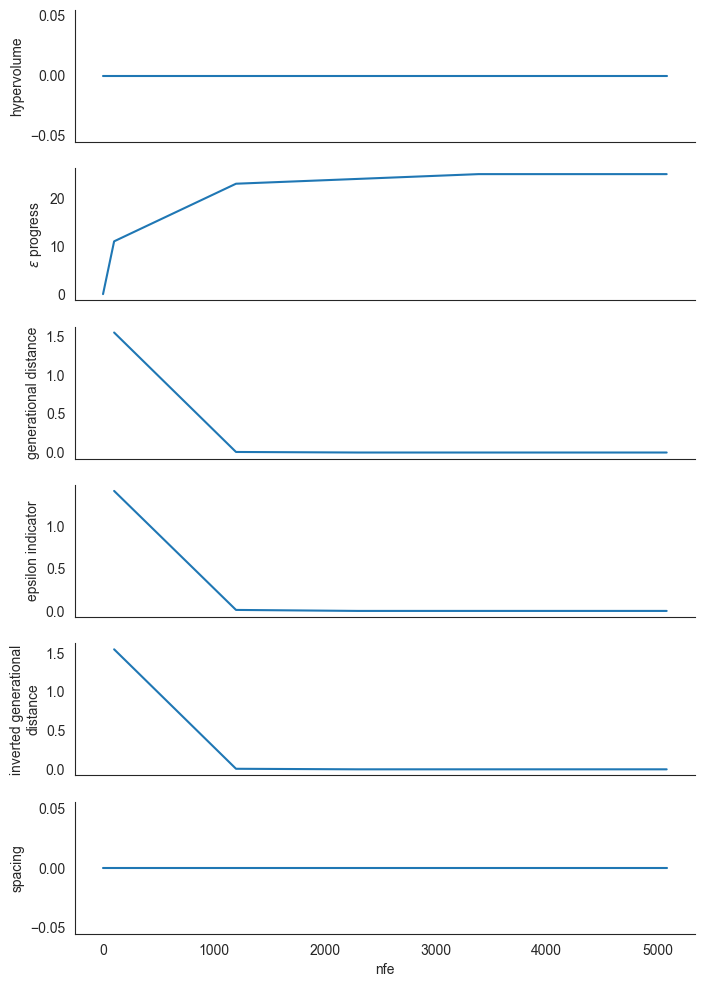

In [23]:
archives = ArchiveLogger.load_archives(os.path.join('experiment', 'optimize_test.tar.gz'))
for key in archives.keys():
    archives[key] = archives[key].drop(columns='Unnamed: 0')
    archives[key] = archives[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in archives[key].columns}) 
    archives[key] = archives[key].rename(columns={ x: x.replace('.', 'z') for x in archives[key].columns})
reference_set = archives[max(archives.keys())] # this is the final archive

metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

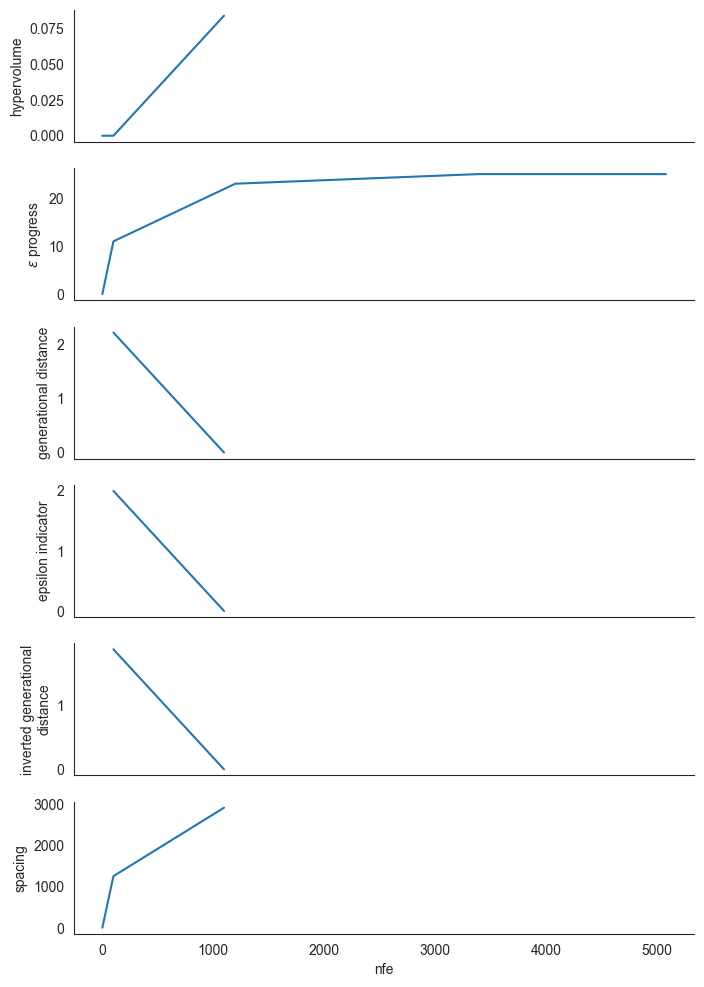

In [74]:
archives = ArchiveLogger.load_archives(os.path.join('experiment', 'results_optimize_box_1_max_1.tar.gz'))
for key in archives.keys():
    archives[key] = archives[key].drop(columns='Unnamed: 0')
    archives[key] = archives[key].rename(columns={ x: 'z_' + "_".join(x.split(" ")) for x in archives[key].columns}) 
    archives[key] = archives[key].rename(columns={ x: x.replace('.', 'z') for x in archives[key].columns})
reference_set = archives[max(archives.keys())] # this is the final archive

metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

In [24]:
results

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths
0,0,1,0,1,0,0,1,1,1,1,...,0,2,8,4,5,1,7,8.244997e+06,0.0,0.002018
1,1,0,0,1,1,1,1,1,1,1,...,0,1,4,2,6,1,4,0.000000e+00,20299287.0,0.000000


In [25]:
convergence

,epsilon_progress,nfe
0,0,0
1,11,100
2,23,1199
3,24,2294
4,25,3386
5,25,4485
6,25,5082


# ---------------------------------------------
# OLD RESULTS - WILL BE REMOVED

In [23]:
df_outcomes

,A.1_Dike Investment Costs,A.1_Expected Annual Damage,A.1_Expected Number of Deaths,A.2_Dike Investment Costs,A.2_Expected Annual Damage,A.2_Expected Number of Deaths,A.3_Dike Investment Costs,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.4_Dike Investment Costs,A.4_Expected Annual Damage,A.4_Expected Number of Deaths,A.5_Dike Investment Costs,A.5_Expected Annual Damage,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,2.760434e+08,0.0,0.0,7.779711e+07,1.336352e+08,0.012321,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,6605.201655
1,2.760434e+08,0.0,0.0,7.779711e+07,4.372356e+07,0.003442,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,1728.294627
2,2.760434e+08,0.0,0.0,7.779711e+07,0.000000e+00,0.000000,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,0.000000
3,2.760434e+08,0.0,0.0,7.779711e+07,1.672455e+07,0.001300,0,0.0,0.0,4.417232e+07,5.761620e+04,0.000003,1.659631e+08,0.0,0.0,1.195400e+09,624.747288
4,2.760434e+08,0.0,0.0,7.779711e+07,0.000000e+00,0.000000,0,0.0,0.0,4.417232e+07,0.000000e+00,0.000000,1.659631e+08,0.0,0.0,1.195400e+09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.839277e+08,0.0,0.0,3.824512e+07,7.488377e+06,0.000560,24198032,0.0,0.0,3.018556e+07,7.764509e+05,0.000022,7.155554e+07,0.0,0.0,1.366900e+09,294.014571
596,1.839277e+08,0.0,0.0,3.824512e+07,0.000000e+00,0.000000,24198032,0.0,0.0,3.018556e+07,3.551073e+06,0.000171,7.155554e+07,0.0,0.0,1.366900e+09,226.222855
597,1.839277e+08,0.0,0.0,3.824512e+07,2.968074e+08,0.020150,24198032,0.0,0.0,3.018556e+07,0.000000e+00,0.000000,7.155554e+07,0.0,0.0,1.366900e+09,11084.668572
598,1.839277e+08,0.0,0.0,3.824512e+07,5.596359e+08,0.029641,24198032,0.0,0.0,3.018556e+07,4.127923e+07,0.000824,7.155554e+07,0.0,0.0,1.366900e+09,18300.107796


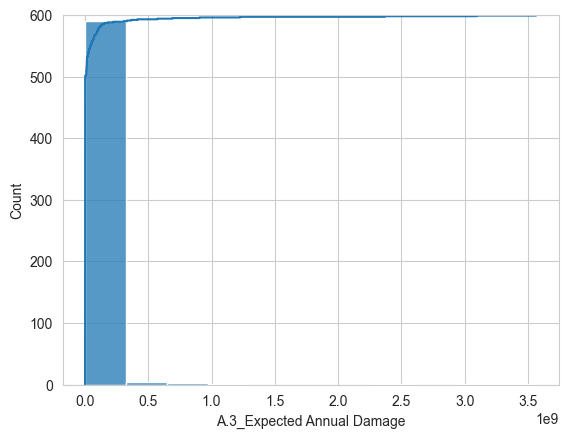

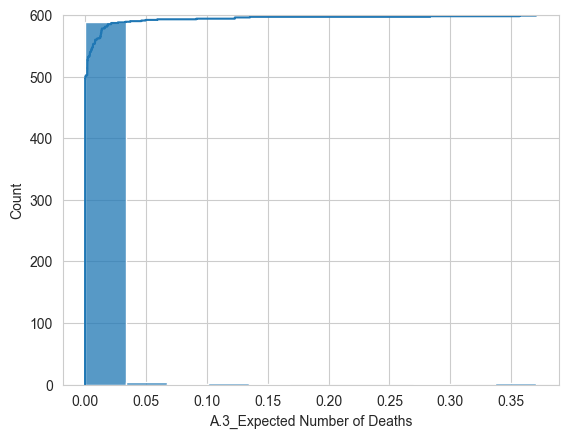

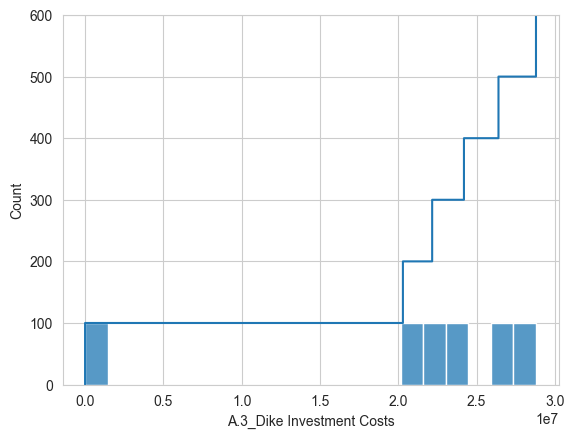

In [28]:
for o in ooi_dr3:
    sns.histplot(df_outcomes, x=o)
    sns.ecdfplot(df_outcomes, x=o, stat='count')
    plt.show()

In [29]:
df_outcomes[ooi_dr3].describe()

,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.3_Dike Investment Costs
count,6.000000e+02,600.000000,6.000000e+02
mean,3.062070e+07,0.003924,2.031115e+07
std,2.288629e+08,0.026193,9.496917e+06
min,0.000000e+00,0.000000,0.000000e+00
25%,0.000000e+00,0.000000,2.029929e+07
50%,0.000000e+00,0.000000,2.318292e+07
75%,0.000000e+00,0.000000,2.640338e+07
max,3.563540e+09,0.370352,2.879840e+07


# Experiment without policies

In [30]:
experiment_0, outcomes_0 = load_results(os.path.join('experiment', 'results_pol0_prb%d.tar.gz' % problem_formulation_id))
df_outcomes_0 = pd.DataFrame(outcomes_0)

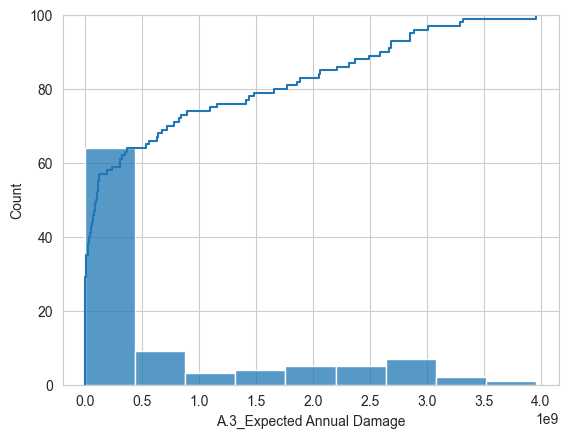

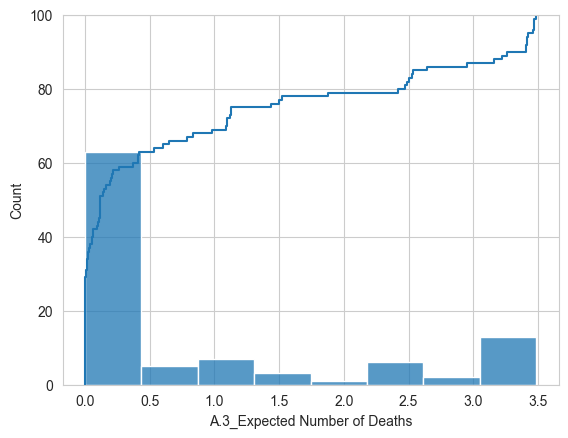

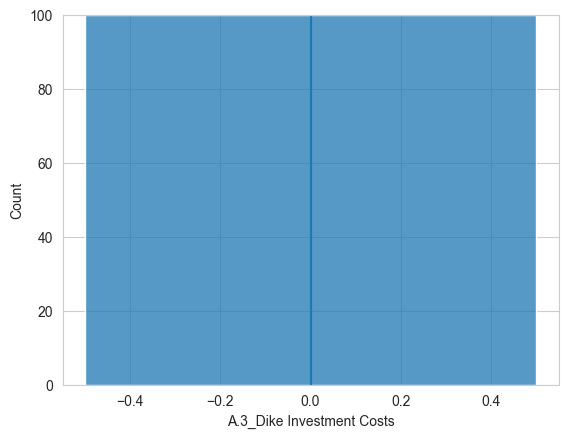

In [32]:
for o in ooi_dr3:
    sns.histplot(df_outcomes_0, x=o)
    sns.ecdfplot(df_outcomes_0, x=o, stat='count')
    plt.show()

In [33]:
df_outcomes_0[ooi_dr3].describe()

,A.3_Expected Annual Damage,A.3_Expected Number of Deaths,A.3_Dike Investment Costs
count,1.000000e+02,100.000000,100.0
mean,7.096184e+08,0.865271,0.0
std,1.040643e+09,1.229727,0.0
min,0.000000e+00,0.000000,0.0
25%,0.000000e+00,0.000000,0.0
50%,1.007798e+08,0.114901,0.0
75%,1.112956e+09,1.204847,0.0
max,3.958337e+09,3.485154,0.0


In [46]:
experiment_0 = []
outcomes_0 = []
df_outcomes_0 = []
for i in range(5):
    experiment_, outcomes_ = load_results(os.path.join('experiment', 'results_pol0_prb%d_sd%d.tar.gz' % (problem_formulation_id, i)))
    
    experiment_.insert(experiment_.shape[1], 'seed', str(i))
    experiment_0.append(experiment_)
    
    outcomes_0.append(outcomes_)
    
    df_outcomes_ = pd.DataFrame(outcomes_)
    df_outcomes_.insert(df_outcomes_.shape[1], 'seed', str(i))
    df_outcomes_0.append(df_outcomes_)
    
experiment_0 = pd.concat(experiment_0, axis=0)
df_outcomes_0 = pd.concat(df_outcomes_0, axis=0)

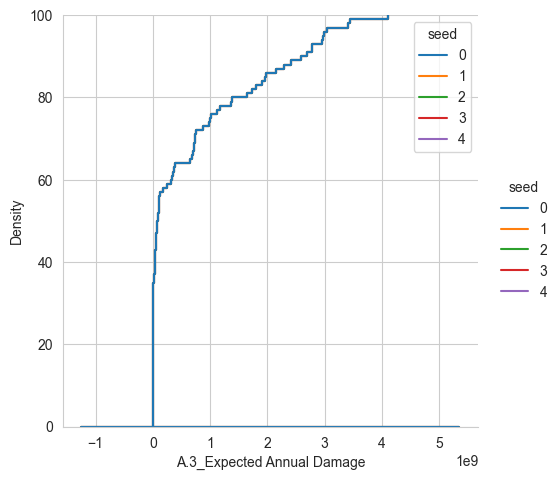

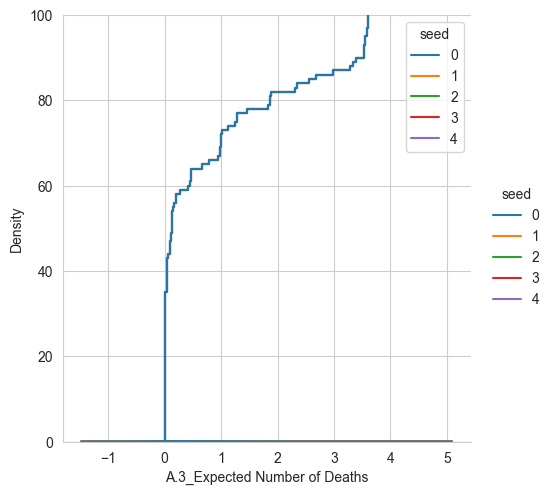

/var/folders/kh/8ls_kfyd28j3v0nb9fsj54g00000gn/T/ipykernel_12817/2164767250.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(df_outcomes_0, x=o, hue='seed', kind='kde')


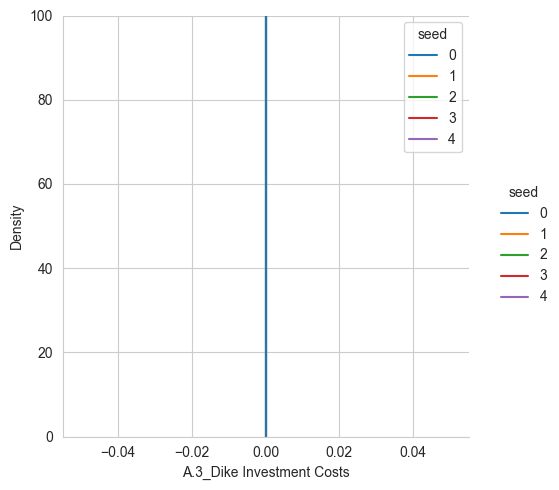

In [48]:
for o in ooi_dr3:
    sns.displot(df_outcomes_0, x=o, hue='seed', kind='kde')
    sns.ecdfplot(df_outcomes_0, x=o, hue='seed', stat='count')
    plt.show()

In [43]:
experiment_0.seed.value_counts()

seed
0    100
1    100
2    100
3    100
4    100
Name: count, dtype: int64